# Set-Up

In [1]:
import jax
import jax.numpy as jnp
import approx_post
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta,0).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = x.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus Predicted Variance", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze(),0), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\theta$")
    plt.ylabel("Posterior Probability Density")

In [5]:
def plot_logpdf_del_x(ammortised_dist, x=None, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    if x is None:
        theta = jnp.atleast_2d(jnp.linspace(-1, 11, 1000)).reshape(1,-1,1)
    amortised_dist.logpdf_del_x(theta, x)
    
    plt.xlabel("Parameter $\theta$")
    plt.ylabel("Observation $x$")
    plt.zlabel("$\partial_x \, \ln{p(\theta|x)}$")

# Artificial Data Creation

In [6]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta, 0).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [7]:
# Define model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [8]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, num_batch)
noise_cov = 1*jnp.identity(ndim)
data = create_data(model_func, true_theta, noise_cov, prngkey)

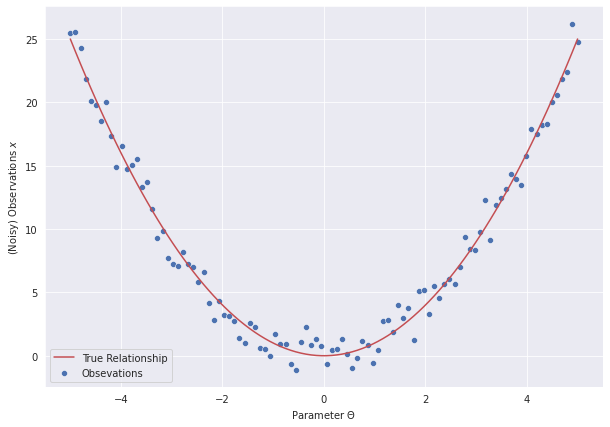

In [9]:
plot_data(data, true_theta, model_func)

# Create Joint Distribution

In [10]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [20]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(ndim)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(data)
phi_lims = None # {'mean': {'lb': 0, 'ub':2}}
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=ndim, prngkey=prngkey, 
                                                                   num_layers=3, width=10, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

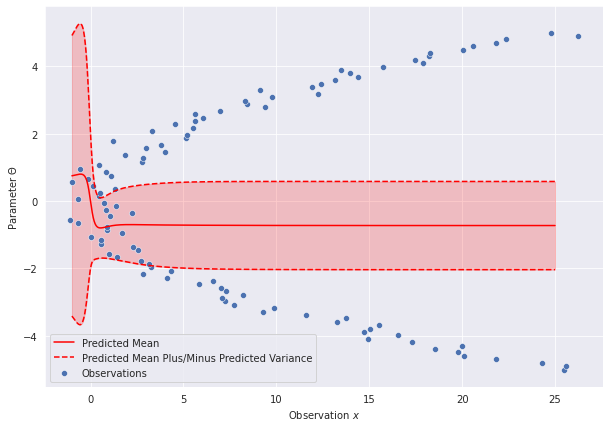

In [21]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [22]:
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=100)

Loss = 62.76002883911133, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8152209 , -0.509059  ,  1.8475323 , -0.83786315,
              -2.0471652 ,  0.5254501 , -0.0938664 , -0.34642637,
               1.4270455 , -0.45711833]], dtype=float32), 'b_0': DeviceArray([-0.09999999,  0.1       , -0.1       ,  0.1       ,
             -0.1       ,  0.1       , -0.1       ,  0.1       ,
             -0.1       ,  0.1       ], dtype=float32), 'W_1': DeviceArray([[ 1.05921775e-02,  1.47245347e-01, -4.93234724e-01,
              -4.91298705e-01,  6.86110198e-01, -4.32136655e-01,
              -3.22556049e-01,  4.87902492e-01,  4.69490647e-01,
              -7.13349581e-01],
             [ 1.18618295e-01, -1.07906306e+00, -2.40713567e-01,
               8.62650990e-01, -8.30588639e-01, -4.66393054e-01,
               2.55859345e-02,  2.30622143e-01, -1.47669882e-01,
               7.98572719e-01],
             [-2.48474687e-01,  4.10802245e-01,  1.25582427e-01,
              -8.55044603e-01, -9.6937

Loss = 41.724647521972656, Params = Jaxtainer({'W_0': DeviceArray([[ 0.9477744 , -0.3776835 ,  1.7165492 , -0.9713588 ,
              -2.1735601 ,  0.6543324 ,  0.03744522, -0.21470425,
               1.296153  , -0.32596833]], dtype=float32), 'b_0': DeviceArray([-0.23369408,  0.23328534, -0.2334986 , -0.03018488,
             -0.2393707 ,  0.23786141,  0.03145457,  0.23259863,
             -0.2328215 ,  0.23349321], dtype=float32), 'W_1': DeviceArray([[ 0.14225712,  0.0158637 , -0.62508166, -0.36214036,
               0.63723874, -0.5640734 , -0.1900352 ,  0.6197926 ,
               0.33761704, -0.5839067 ],
             [-0.01312843, -0.9475225 , -0.1088562 ,  0.73473144,
              -0.7233199 , -0.33444434, -0.10702877,  0.09871706,
              -0.01574433,  0.6685902 ],
             [-0.11698549,  0.27970138, -0.00623892, -0.72496337,
               0.07045576, -0.52871096,  0.46955258,  0.06455594,
              -0.06041552, -0.09150579],
             [ 0.48053303,  0.1767979

Loss = 47.56415939331055, Params = Jaxtainer({'W_0': DeviceArray([[ 1.0344167 , -0.2908113 ,  1.6295506 , -1.0598332 ,
              -2.2567046 ,  0.73917985,  0.12252484, -0.1278869 ,
               1.2101576 , -0.23952259]], dtype=float32), 'b_0': DeviceArray([-0.32284373,  0.32135576, -0.32175377, -0.11583968,
             -0.3315501 ,  0.3292215 ,  0.11783332,  0.32011968,
             -0.3203823 ,  0.32167482], dtype=float32), 'W_1': DeviceArray([[ 0.22868541, -0.06775665, -0.7119632 , -0.28255224,
               0.60172355, -0.65110105, -0.10268328,  0.7066753 ,
               0.25032195, -0.49864224],
             [-0.09959364, -0.86479694, -0.02197054,  0.65975744,
              -0.6527575 , -0.24738723, -0.19441481,  0.01182473,
               0.07162231,  0.58360076],
             [-0.03066785,  0.19549772, -0.09310514, -0.64245003,
               0.17627265, -0.6157157 ,  0.5568462 ,  0.15141994,
              -0.14762081, -0.00642392],
             [ 0.394109  ,  0.2604916 

Loss = 53.977298736572266, Params = Jaxtainer({'W_0': DeviceArray([[ 1.0983344 , -0.22694254,  1.5643762 , -1.1255676 ,
              -2.316985  ,  0.8012877 ,  0.18504655, -0.06732173,
               1.1471951 , -0.17473558]], dtype=float32), 'b_0': DeviceArray([-0.38803947,  0.38596785, -0.38626158, -0.17903231,
             -0.40122256,  0.3978385 ,  0.18147464,  0.38420272,
             -0.3857922 ,  0.38793805], dtype=float32), 'W_1': DeviceArray([[ 0.29238158, -0.12175839, -0.7762174 , -0.25196233,
               0.5630838 , -0.7155014 , -0.03803182,  0.7708178 ,
               0.18506622, -0.4390353 ],
             [-0.16330324, -0.81360775,  0.04228694,  0.6449575 ,
              -0.59779096, -0.18295744, -0.25906813, -0.05232882,
               0.13700552,  0.5249499 ],
             [ 0.03295168,  0.13920692, -0.15734804, -0.6000091 ,
               0.24462804, -0.6800952 ,  0.6214593 ,  0.21554708,
              -0.21275522,  0.0542606 ],
             [ 0.33042255,  0.3145150

Loss = 41.05129623413086, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1480246 , -0.17803222,  1.5123074 , -1.1752019 ,
              -2.360231  ,  0.8481054 ,  0.23364246, -0.0340192 ,
               1.099663  , -0.12263139]], dtype=float32), 'b_0': DeviceArray([-0.43890616,  0.43511212, -0.4350534 , -0.22903764,
             -0.45922735,  0.4532994 ,  0.23060393,  0.4322101 ,
             -0.43786645,  0.44148302], dtype=float32), 'W_1': DeviceArray([[ 0.34172624, -0.16059668, -0.8260607 , -0.25933176,
               0.52892256, -0.76547414,  0.01223128,  0.8205341 ,
               0.13416149, -0.3998494 ],
             [-0.21264488, -0.7782592 ,  0.09213471,  0.67825186,
              -0.5544343 , -0.13295878, -0.3092966 , -0.10205631,
               0.18810119,  0.48762804],
             [ 0.08224149,  0.09781477, -0.20718224, -0.5879353 ,
               0.2944406 , -0.73005027,  0.6716923 ,  0.26525128,
              -0.2635331 ,  0.09679148],
             [ 0.2810959 ,  0.35307717

Loss = 33.408260345458984, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1873991 , -0.13812187,  1.4670719 , -1.2080574 ,
              -2.3842802 ,  0.8818691 ,  0.27240285, -0.01700597,
               1.0643398 , -0.08190492]], dtype=float32), 'b_0': DeviceArray([-0.48408154,  0.4733932 , -0.47290778, -0.27369514,
             -0.51655364,  0.50338984,  0.26903048,  0.4690306 ,
             -0.48155582,  0.4867248 ], dtype=float32), 'W_1': DeviceArray([[ 0.38100848, -0.19293116, -0.8657142 , -0.25560534,
               0.5095661 , -0.80525297,  0.0524113 ,  0.8600779 ,
               0.09393299, -0.37874886],
             [-0.25189498, -0.7497473 ,  0.1317979 ,  0.7127725 ,
              -0.5239329 , -0.09315117, -0.3493155 , -0.14161731,
               0.2286374 ,  0.46880248],
             [ 0.12148706,  0.06366361, -0.24682793, -0.5702715 ,
               0.33931717, -0.7698121 ,  0.7118579 ,  0.30478486,
              -0.30365726,  0.12404224],
             [ 0.24183805,  0.3846158

Loss = 31.519195556640625, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2177004 , -0.10396631,  1.4249691 , -1.2280735 ,
              -2.3924453 ,  0.9056237 ,  0.3037057 , -0.0049323 ,
               1.0377538 , -0.04996301]], dtype=float32), 'b_0': DeviceArray([-0.5306217 ,  0.5042651 , -0.50475246, -0.3159301 ,
             -0.57536304,  0.55012083,  0.29930997,  0.49835598,
             -0.5185928 ,  0.524983  ], dtype=float32), 'W_1': DeviceArray([[ 0.41277042, -0.22112603, -0.8977444 , -0.22782071,
               0.489295  , -0.8374152 ,  0.08504155,  0.89200723,
               0.06175001, -0.3693591 ],
             [-0.2836014 , -0.72556317,  0.16384459,  0.73882   ,
              -0.5055724 , -0.06095532, -0.38154933, -0.17358707,
               0.2612008 ,  0.4606062 ],
             [ 0.15322673,  0.03439387, -0.27885085, -0.53697497,
               0.37068957, -0.8019551 ,  0.7445111 ,  0.3367034 ,
              -0.33576253,  0.14100772],
             [ 0.21009178,  0.4117188

Loss = 29.64324188232422, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2402451 , -0.07492899,  1.3859508 , -1.2445966 ,
              -2.3951607 ,  0.92392844,  0.32910448,  0.00338135,
               1.0166864 , -0.02480482]], dtype=float32), 'b_0': DeviceArray([-0.5781496 ,  0.5299643 , -0.5334503 , -0.35284033,
             -0.6284224 ,  0.5904687 ,  0.32357976,  0.5223768 ,
             -0.5491286 ,  0.55611813], dtype=float32), 'W_1': DeviceArray([[ 0.4387015 , -0.24485351, -0.9238744 , -0.18798856,
               0.44082293, -0.86367327,  0.1117461 ,  0.9180421 ,
               0.03559599, -0.36622933],
             [-0.30944732, -0.7056313 ,  0.18999575,  0.76578784,
              -0.49523556, -0.03467257, -0.4076494 , -0.19969033,
               0.2876996 ,  0.45905358],
             [ 0.17914972,  0.00992662, -0.30497354, -0.49646163,
               0.37073743, -0.8281942 ,  0.7712758 ,  0.36272615,
              -0.36185595,  0.15192346],
             [ 0.1841428 ,  0.43441957

Loss = 29.630130767822266, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2566992 , -0.05275628,  1.3499892 , -1.2595662 ,
              -2.3968365 ,  0.9387309 ,  0.3497985 ,  0.00787344,
               1.0000405 , -0.0040069 ]], dtype=float32), 'b_0': DeviceArray([-0.6276238 ,  0.55170906, -0.56070226, -0.38452023,
             -0.67288405,  0.6240141 ,  0.34316257,  0.54234314,
             -0.57389206,  0.5808832 ], dtype=float32), 'W_1': DeviceArray([[ 0.46009734, -0.26417634, -0.9453288 , -0.14584343,
               0.38417038, -0.8852437 ,  0.13372429,  0.9394264 ,
               0.01415353, -0.3670297 ],
             [-0.33063078, -0.6895847 ,  0.2114768 ,  0.8006825 ,
              -0.49566013, -0.01308919, -0.4288466 , -0.22115654,
               0.30943725,  0.46143085],
             [ 0.20055255, -0.01004694, -0.3264203 , -0.4555869 ,
               0.35668474, -0.84974676,  0.7933436 ,  0.38409564,
              -0.38324907,  0.15873823],
             [ 0.16269423,  0.4529053

Loss = 29.785850524902344, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2675666 , -0.04072979,  1.3158032 , -1.2735502 ,
              -2.3978972 ,  0.95072013,  0.3667207 ,  0.009873  ,
               0.9871673 ,  0.01710123]], dtype=float32), 'b_0': DeviceArray([-0.6838337 ,  0.57004863, -0.58837014, -0.41241428,
             -0.7091915 ,  0.6515326 ,  0.35903448,  0.5592465 ,
             -0.59427756,  0.60075754], dtype=float32), 'W_1': DeviceArray([[ 0.47791436, -0.27981877, -0.9630191 , -0.1071799 ,
               0.35487133, -0.9030333 ,  0.15189281,  0.95707697,
              -0.00349447, -0.36950055],
             [-0.34803325, -0.67657685,  0.22920102,  0.84486145,
              -0.5074718 ,  0.00471982, -0.4460702 , -0.23890053,
               0.3273622 ,  0.4644225 ],
             [ 0.21838355, -0.02629507, -0.34410232, -0.418246  ,
               0.35522142, -0.8675168 ,  0.8116253 ,  0.40172493,
              -0.4008568 ,  0.16320586],
             [ 0.14483643,  0.4678910

Loss = 28.198015213012695, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2729232 , -0.04292253,  1.2820776 , -1.2870574 ,
              -2.3982816 ,  0.9603867 ,  0.38057637,  0.00963056,
               0.97741693,  0.03844138]], dtype=float32), 'b_0': DeviceArray([-0.74943125,  0.5853734 , -0.61738396, -0.43739146,
             -0.73854333,  0.67394596,  0.371934  ,  0.5738472 ,
             -0.61131567,  0.6167109 ], dtype=float32), 'W_1': DeviceArray([[ 0.49282968, -0.29250187, -0.9776472 , -0.07469463,
               0.37292516, -0.9177428 ,  0.16695516,  0.9716876 ,
              -0.01805204, -0.37259465],
             [-0.362345  , -0.6659365 ,  0.24387111,  0.8985894 ,
              -0.5288104 ,  0.01948436, -0.45998463, -0.25362575,
               0.34219825,  0.46704832],
             [ 0.23331247, -0.03953966, -0.35872102, -0.3861174 ,
               0.38178578, -0.8821996 ,  0.8268333 ,  0.41630518,
              -0.41538128,  0.16623713],
             [ 0.1299202 ,  0.4800756

Loss = 23.23838996887207, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2732764 , -0.06064264,  1.2482202 , -1.3003178 ,
              -2.3982422 ,  0.96823525,  0.391895  ,  0.00523286,
               0.9701234 ,  0.05743742]], dtype=float32), 'b_0': DeviceArray([-0.82194114,  0.5983508 , -0.64717025, -0.45960286,
             -0.7623581 ,  0.6922574 ,  0.38237277,  0.5865081 ,
             -0.62542504,  0.62922955], dtype=float32), 'W_1': DeviceArray([[ 0.5053901 , -0.3027256 , -0.98976576, -0.04548018,
               0.41153687, -0.929928  ,  0.17946991,  0.9838043 ,
              -0.03007117, -0.37618548],
             [-0.37413144, -0.65727556,  0.2560385 ,  0.96583927,
              -0.563506  ,  0.03177176, -0.47109136, -0.26587844,
               0.35450542,  0.4694866 ],
             [ 0.2458869 , -0.05029743, -0.37082875, -0.3569889 ,
               0.4185703 , -0.8943466 ,  0.8395435 ,  0.42838368,
              -0.4273732 ,  0.16810548],
             [ 0.1173697 ,  0.48993406

Loss = 16.3009090423584, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2696770e+00, -7.7763386e-02,  1.2145840e+00,
              -1.3132372e+00, -2.3981631e+00,  9.7470427e-01,
               4.0111122e-01, -1.0208967e-03,  9.6395850e-01,
               7.1729898e-02]], dtype=float32), 'b_0': DeviceArray([-0.8951155 ,  0.6110661 , -0.67605066, -0.47897246,
             -0.7820015 ,  0.70739657,  0.39078182,  0.5977373 ,
             -0.63728637,  0.6387218 ], dtype=float32), 'W_1': DeviceArray([[ 5.15903890e-01, -3.11041325e-01, -9.99816775e-01,
              -3.60559672e-04,  3.83120477e-01, -9.40022707e-01,
               1.89896405e-01,  9.93839562e-01, -4.00048681e-02,
              -3.79451364e-01],
             [-3.83874536e-01, -6.50304615e-01,  2.66139656e-01,
               1.04738939e+00, -6.14398301e-01,  4.20053899e-02,
              -4.79937255e-01, -2.76081204e-01,  3.64729255e-01,
               4.72068399e-01],
             [ 2.56414086e-01, -5.90981282e-02, -3.80868554e

Loss = 12.913283348083496, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2649392 , -0.10299879,  1.1847141 , -1.3246442 ,
              -2.3981872 ,  0.98005456,  0.4087342 , -0.01746979,
               0.95816106,  0.08422377]], dtype=float32), 'b_0': DeviceArray([-0.9603938 ,  0.6211509 , -0.701134  , -0.49523634,
             -0.7983859 ,  0.7199604 ,  0.3977217 ,  0.6065928 ,
             -0.64747286,  0.64656335], dtype=float32), 'W_1': DeviceArray([[ 0.52459496, -0.31774303, -1.0081604 ,  0.01989863,
               0.39322555, -0.94838065,  0.1984954 ,  1.002159  ,
              -0.04824466, -0.38235223],
             [-0.3919756 , -0.6447347 ,  0.27452624,  1.1383092 ,
              -0.6710401 ,  0.05051102, -0.48712227, -0.28456175,
               0.37322405,  0.4748792 ],
             [ 0.26511052, -0.06625077, -0.38920188, -0.29624766,
               0.41029093, -0.91271514,  0.85903203,  0.44666123,
              -0.44550484,  0.17052643],
             [ 0.0981901 ,  0.504493 

Loss = 10.7901611328125, Params = Jaxtainer({'W_0': DeviceArray([[ 1.260509  , -0.12786031,  1.1598021 , -1.33423   ,
              -2.3983836 ,  0.9844586 ,  0.4150949 , -0.03793067,
               0.95251083,  0.09497227]], dtype=float32), 'b_0': DeviceArray([-1.0156721 ,  0.628934  , -0.7218767 , -0.5085477 ,
             -0.81203586,  0.7303356 ,  0.4035414 ,  0.6137217 ,
             -0.6564213 ,  0.6532124 ], dtype=float32), 'W_1': DeviceArray([[ 0.53175056, -0.32323605, -1.0150899 ,  0.02450246,
               0.4398332 , -0.9553052 ,  0.20551576,  1.009061  ,
              -0.05509549, -0.3846916 ],
             [-0.39874232, -0.64018327,  0.2814891 ,  1.2217003 ,
              -0.71964   ,  0.05757709, -0.49303803, -0.29159883,
               0.38027912,  0.47723716],
             [ 0.2722548 , -0.07213649, -0.3961227 , -0.28764594,
               0.45019284, -0.9196056 ,  0.86626863,  0.45353395,
              -0.45233926,  0.17143692],
             [ 0.0911156 ,  0.5098393 ,

Loss = 10.50196361541748, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2568077 , -0.13838178,  1.1394256 , -1.3422495 ,
              -2.3988662 ,  0.9880399 ,  0.4204068 , -0.04620223,
               0.9469177 ,  0.10258445]], dtype=float32), 'b_0': DeviceArray([-1.0617435 ,  0.63675034, -0.7388139 , -0.51918966,
             -0.8232894 ,  0.7388382 ,  0.4084734 ,  0.62114316,
             -0.66450274,  0.6586664 ], dtype=float32), 'W_1': DeviceArray([[ 0.5376699 , -0.32785684, -1.0208457 ,  0.05159048,
               0.47764328, -0.961035  ,  0.21122657,  1.0147885 ,
              -0.06077912, -0.38603383],
             [-0.40444136, -0.63637775,  0.2872687 ,  1.2757511 ,
              -0.75455683,  0.0634583 , -0.4979426 , -0.2974329 ,
               0.38613126,  0.47874665],
             [ 0.2781355 , -0.07707296, -0.40187144, -0.2637245 ,
               0.48384658, -0.9253013 ,  0.87217015,  0.45924002,
              -0.4580101 ,  0.1725794 ],
             [ 0.08538097,  0.51435673

Loss = 10.25326156616211, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2539787 , -0.14546028,  1.1227766 , -1.3489374 ,
              -2.3996782 ,  0.99094206,  0.42485106, -0.05203445,
               0.94143933,  0.10887688]], dtype=float32), 'b_0': DeviceArray([-1.0994966 ,  0.64312774, -0.7526099 , -0.5275537 ,
             -0.8325097 ,  0.7457739 ,  0.41266516,  0.62763405,
             -0.67181945,  0.66337734], dtype=float32), 'W_1': DeviceArray([[ 0.54254764, -0.3317141 , -1.0256264 ,  0.0757879 ,
               0.51204306, -0.96577346,  0.21583831,  1.0195377 ,
              -0.06550711, -0.38692623],
             [-0.4092486 , -0.6332255 ,  0.29206473,  1.3156383 ,
              -0.7797657 ,  0.06836812, -0.50200176, -0.30226225,
               0.3909897 ,  0.4799465 ],
             [ 0.2829465 , -0.08119156, -0.40664676, -0.24269833,
               0.51587427, -0.9299996 ,  0.8769505 ,  0.46397617,
              -0.46272725,  0.17367524],
             [ 0.08079422,  0.51814985

Loss = 9.729148864746094, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2519913 , -0.15507652,  1.1091466 , -1.3546802 ,
              -2.4008567 ,  0.99334896,  0.4285585 , -0.062691  ,
               0.9363833 ,  0.11473373]], dtype=float32), 'b_0': DeviceArray([-1.1296351 ,  0.64752656, -0.76371336, -0.53404033,
             -0.8400579 ,  0.7514471 ,  0.41618717,  0.63231605,
             -0.67813057,  0.6675021 ], dtype=float32), 'W_1': DeviceArray([[ 0.5465505 , -0.33492318, -1.0295964 ,  0.08236298,
               0.5389918 , -0.96969134,  0.21952799,  1.0234684 ,
              -0.06944974, -0.38757637],
             [-0.4132725 , -0.6306341 ,  0.29604408,  1.3552607 ,
              -0.79858565,  0.07246443, -0.505317  , -0.30625388,
               0.39502892,  0.48118374],
             [ 0.28687122, -0.0846183 , -0.41061255, -0.23511745,
               0.54233634, -0.9338738 ,  0.88080364,  0.46790192,
              -0.46665952,  0.1746448 ],
             [ 0.07711872,  0.52131677

Loss = 9.737600326538086, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2506382 , -0.16148034,  1.0979923 , -1.3598058 ,
              -2.40243   ,  0.9953769 ,  0.43163642, -0.06229525,
               0.93204194,  0.11957046]], dtype=float32), 'b_0': DeviceArray([-1.1533366 ,  0.65102226, -0.772476  , -0.539044  ,
             -0.8462213 ,  0.75615877,  0.41910008,  0.6368968 ,
             -0.6832348 ,  0.67097133], dtype=float32), 'W_1': DeviceArray([[ 0.54984885, -0.33766443, -1.0328926 ,  0.09723379,
               0.55807316, -0.972927  ,  0.2224467 ,  1.0267181 ,
              -0.07273004, -0.38731194],
             [-0.4166194 , -0.6284231 ,  0.29934576,  1.3716629 ,
              -0.8133892 ,  0.07586395, -0.5079693 , -0.30955267,
               0.39838168,  0.48152068],
             [ 0.2900985 , -0.08752252, -0.41390464, -0.22195758,
               0.5620083 , -0.93707055,  0.8838996 ,  0.4711528 ,
              -0.46992993,  0.17595837],
             [ 0.07410905,  0.5240207 

Loss = 9.242927551269531, Params = Jaxtainer({'W_0': DeviceArray([[ 1.249602  , -0.16619658,  1.0887592 , -1.3646256 ,
              -2.404379  ,  0.99712896,  0.43418315, -0.05183974,
               0.928445  ,  0.12360902]], dtype=float32), 'b_0': DeviceArray([-1.1722528 ,  0.6536538 , -0.77935976, -0.5428528 ,
             -0.85123044,  0.7600733 ,  0.42148402,  0.64136165,
             -0.6871999 ,  0.6738545 ], dtype=float32), 'W_1': DeviceArray([[ 0.5525611 , -0.3400396 , -1.0356286 ,  0.11881432,
               0.57063186, -0.9755944 ,  0.2247143 ,  1.0294007 ,
              -0.07546102, -0.38605756],
             [-0.41938224, -0.62650204,  0.30208516,  1.3682534 ,
              -0.82562906,  0.07867029, -0.5100378 , -0.31227836,
               0.40116584,  0.4808381 ],
             [ 0.29275388, -0.09000894, -0.41663638, -0.20426175,
               0.5754222 , -0.9397094 ,  0.88636994,  0.47383985,
              -0.4726509 ,  0.17769976],
             [ 0.0716184 ,  0.52635473

Loss = 8.872251510620117, Params = Jaxtainer({'W_0': DeviceArray([[ 1.248575  , -0.17482902,  1.0809224 , -1.3693671 ,
              -2.4066455 ,  0.9986876 ,  0.43628535, -0.05300419,
               0.92549896,  0.12746936]], dtype=float32), 'b_0': DeviceArray([-1.1879987 ,  0.6549585 , -0.78484267, -0.54568714,
             -0.8552828 ,  0.76328844,  0.42342207,  0.6438687 ,
             -0.6902124 ,  0.6762817 ], dtype=float32), 'W_1': DeviceArray([[ 0.55477   , -0.34205142, -1.0378993 ,  0.11765187,
               0.5784035 , -0.97778994,  0.22642925,  1.031609  ,
              -0.07774553, -0.38466954],
             [-0.42163503, -0.62489796,  0.3043581 ,  1.3807286 ,
              -0.8363283 ,  0.08097648, -0.5115981 , -0.314529  ,
               0.40348718,  0.4803189 ],
             [ 0.29492086, -0.09210197, -0.4189024 , -0.203522  ,
               0.5836891 , -0.94188863,  0.88831824,  0.47605398,
              -0.47492436,  0.17935577],
             [ 0.06956195,  0.52831876

Loss = 8.505273818969727, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2472243 , -0.18205021,  1.073898  , -1.3740741 ,
              -2.4091978 ,  1.0000452 ,  0.43801585, -0.03824582,
               0.9231027 ,  0.13065073]], dtype=float32), 'b_0': DeviceArray([-1.2021943 ,  0.6557545 , -0.78941894, -0.5477895 ,
             -0.85850126,  0.76596826,  0.42498848,  0.6471108 ,
             -0.6925008 ,  0.67826575], dtype=float32), 'W_1': DeviceArray([[ 0.5565942 , -0.3438358 , -1.0397834 ,  0.13265671,
               0.5833933 , -0.9795926 ,  0.22768892,  1.0334266 ,
              -0.07964632, -0.38241068],
             [-0.42347357, -0.6234465 ,  0.3062439 ,  1.3659585 ,
              -0.84621793,  0.08286004, -0.51272696, -0.31639048,
               0.4054152 ,  0.47860104],
             [ 0.296717  , -0.09392574, -0.4207811 , -0.19112296,
               0.5881471 , -0.94368774,  0.88984215,  0.47787657,
              -0.4768139 ,  0.18142408],
             [ 0.06782642,  0.5300499 

Loss = 9.334776878356934, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2452815 , -0.18933426,  1.0672028 , -1.3787812 ,
              -2.411981  ,  1.0012088 ,  0.43943578, -0.03897911,
               0.9211509 ,  0.13335514]], dtype=float32), 'b_0': DeviceArray([-1.2161095 ,  0.65611523, -0.7934946 , -0.5493432 ,
             -0.8610144 ,  0.76822793,  0.42624676,  0.6490101 ,
             -0.6942649 ,  0.6798822 ], dtype=float32), 'W_1': DeviceArray([[ 0.5581043 , -0.34532306, -1.0413465 ,  0.13394304,
               0.58775574, -0.98107165,  0.22857022,  1.0349195 ,
              -0.08123092, -0.38063887],
             [-0.4249538 , -0.6222384 ,  0.30780873,  1.3650138 ,
              -0.8561822 ,  0.084391  , -0.5134867 , -0.31793064,
               0.4070229 ,  0.47734404],
             [ 0.2982109 , -0.0954424 , -0.4223381 , -0.18895563,
               0.5903913 , -0.9451753 ,  0.8910176 ,  0.47937194,
              -0.47838682,  0.1830678 ],
             [ 0.06634983,  0.5314817 

Loss = 10.25644588470459, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2425051 , -0.19510095,  1.0604041 , -1.3834883 ,
              -2.4149566 ,  1.0021746 ,  0.44059655, -0.05571948,
               0.919514  ,  0.13546707]], dtype=float32), 'b_0': DeviceArray([-1.230748  ,  0.6563826 , -0.797401  , -0.5504999 ,
             -0.8629272 ,  0.7701768 ,  0.427251  ,  0.6496687 ,
             -0.69569093,  0.68117034], dtype=float32), 'W_1': DeviceArray([[ 0.5593748 , -0.34653232, -1.0426432 ,  0.12635213,
               0.5929148 , -0.9822836 ,  0.22914213,  1.0361444 ,
              -0.08254778, -0.37963295],
             [-0.42613733, -0.6212489 ,  0.30910736,  1.3736999 ,
              -0.866802  ,  0.08562804, -0.51393574, -0.31920692,
               0.40836394,  0.47668976],
             [ 0.29947495, -0.09668023, -0.42362785, -0.19433059,
               0.59147996, -0.9464067 ,  0.89191103,  0.48059583,
              -0.47969183,  0.18413183],
             [ 0.06506737,  0.5326363 

Loss = 10.32533073425293, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2386434 , -0.18955988,  1.0530444 , -1.3880643 ,
              -2.4180644 ,  1.002885  ,  0.44153696, -0.040571  ,
               0.918003  ,  0.13594502]], dtype=float32), 'b_0': DeviceArray([-1.2469072 ,  0.6581385 , -0.8014168 , -0.5514282 ,
             -0.86435306,  0.7719798 ,  0.42803976,  0.6547488 ,
             -0.6969684 ,  0.6820356 ], dtype=float32), 'W_1': DeviceArray([[ 0.5605042 , -0.3476154 , -1.0437182 ,  0.17254673,
               0.5978718 , -0.9832706 ,  0.22947073,  1.0371522 ,
              -0.08361487, -0.37797534],
             [-0.42711043, -0.62029225,  0.31018502,  1.3274076 ,
              -0.8776746 ,  0.08661785, -0.51413345, -0.3202699 ,
               0.40946344,  0.47451082],
             [ 0.30060494, -0.09776819, -0.4246954 , -0.1556202 ,
               0.59050316, -0.94742274,  0.8925843 ,  0.48159894,
              -0.48074877,  0.18553838],
             [ 0.0638918 ,  0.5336705 

Loss = 9.781229972839355, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2341374 , -0.18615475,  1.045665  , -1.3926923 ,
              -2.4212296 ,  1.003541  ,  0.4423029 , -0.09404599,
               0.9165523 ,  0.13648888]], dtype=float32), 'b_0': DeviceArray([-1.2633568 ,  0.6594894 , -0.80521727, -0.5520273 ,
             -0.86544424,  0.77346826,  0.42865872,  0.6527479 ,
             -0.6980303 ,  0.68270284], dtype=float32), 'W_1': DeviceArray([[ 0.56141067, -0.34848526, -1.0446105 ,  0.15000327,
               0.60223436, -0.9840748 ,  0.2295678 ,  1.037968  ,
              -0.08452338, -0.3772019 ],
             [-0.42784062, -0.61954653,  0.31107983,  1.3575763 ,
              -0.88863194,  0.08740862, -0.51411355, -0.32114524,
               0.41040292,  0.47363055],
             [ 0.3015175 , -0.0986469 , -0.42557976, -0.17487329,
               0.5879453 , -0.9482636 ,  0.8930474 ,  0.48240846,
              -0.48164538,  0.18631393],
             [ 0.06291321,  0.53448665

Loss = 10.021227836608887, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2288516 , -0.17377615,  1.038005  , -1.3973441 ,
              -2.424518  ,  1.0041271 ,  0.4429233 , -0.1091817 ,
               0.91490597,  0.13607384]], dtype=float32), 'b_0': DeviceArray([-1.2802857 ,  0.66177166, -0.8088982 , -0.5523637 ,
             -0.86619747,  0.77473545,  0.4291427 ,  0.6554863 ,
             -0.699037  ,  0.68310595], dtype=float32), 'W_1': DeviceArray([[ 0.5621996 , -0.34948415, -1.0453509 ,  0.18250103,
               0.6000224 , -0.9847222 ,  0.22948417,  1.0386323 ,
              -0.08525961, -0.3736374 ],
             [-0.42844012, -0.61858124,  0.31182235,  1.3292571 ,
              -0.8969024 ,  0.08803178, -0.51393163, -0.32187188,
               0.41117027,  0.46870983],
             [ 0.30231532, -0.09958902, -0.42631185, -0.1456985 ,
               0.5789807 , -0.94895357,  0.8933456 ,  0.48306563,
              -0.48237103,  0.1888069 ],
             [ 0.06203805,  0.5354293

Loss = 12.28962230682373, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2230667 , -0.16779697,  1.0303805 , -1.4019383 ,
              -2.4275649 ,  1.0047424 ,  0.44343284, -0.1280013 ,
               0.9129096 ,  0.1360558 ]], dtype=float32), 'b_0': DeviceArray([-1.2968731 ,  0.6631633 , -0.8122826 , -0.5524692 ,
             -0.86697674,  0.7757124 ,  0.4295061 ,  0.65662414,
             -0.69996727,  0.6834071 ], dtype=float32), 'W_1': DeviceArray([[ 0.5628317 , -0.35010424, -1.0459661 ,  0.17046216,
               0.6008006 , -0.98523986,  0.22923265,  1.0391656 ,
              -0.08589164, -0.37279552],
             [-0.4289078 , -0.6180769 ,  0.3124389 ,  1.3461511 ,
              -0.9086369 ,  0.08852255, -0.5136151 , -0.32246932,
               0.41182604,  0.46799928],
             [ 0.3029564 , -0.10020851, -0.42691877, -0.156144  ,
               0.57198817, -0.9495171 ,  0.8934896 ,  0.4835932 ,
              -0.48299116,  0.1895208 ],
             [ 0.06131712,  0.53599393

Loss = 10.819680213928223, Params = Jaxtainer({'W_0': DeviceArray([[ 1.216921  , -0.16051158,  1.0228498 , -1.4064696 ,
              -2.430554  ,  1.0053585 ,  0.4438493 , -0.14273886,
               0.9105902 ,  0.13599278]], dtype=float32), 'b_0': DeviceArray([-1.3129447 ,  0.66454625, -0.81534225, -0.55237466,
             -0.8676461 ,  0.77647775,  0.42978016,  0.6575441 ,
             -0.70086443,  0.6836012 ], dtype=float32), 'W_1': DeviceArray([[ 0.56334525, -0.3506102 , -1.0464777 ,  0.15385997,
               0.59714633, -0.98564863,  0.2288452 ,  1.0395924 ,
              -0.08642435, -0.3721963 ],
             [-0.42928186, -0.6177032 ,  0.31295082,  1.3674623 ,
              -0.91926163,  0.08890598, -0.51319486, -0.32295975,
               0.41237828,  0.46786755],
             [ 0.30347666, -0.10071575, -0.42742196, -0.1707058 ,
               0.5610974 , -0.94997346,  0.8935076 ,  0.4840161 ,
              -0.48351192,  0.19004261],
             [ 0.06072154,  0.5364479

Loss = 9.235505104064941, Params = Jaxtainer({'W_0': DeviceArray([[ 1.211014  , -0.14142606,  1.0159123 , -1.4108279 ,
              -2.4337323 ,  1.0059065 ,  0.44418222, -0.14601569,
               0.9083189 ,  0.13528925]], dtype=float32), 'b_0': DeviceArray([-1.327454  ,  0.66720456, -0.81781566, -0.5521147 ,
             -0.86801624,  0.7771556 ,  0.42999056,  0.6597267 ,
             -0.7015904 ,  0.6836594 ], dtype=float32), 'W_1': DeviceArray([[ 0.5637827 , -0.3512543 , -1.046903  ,  0.17069086,
               0.58072764, -0.9859662 ,  0.22835255,  1.0399344 ,
              -0.08685537, -0.36946762],
             [-0.4295914 , -0.61714125,  0.31337574,  1.3564439 ,
              -0.92288357,  0.08920226, -0.5126967 , -0.3233607 ,
               0.4128299 ,  0.46481192],
             [ 0.3039187 , -0.10131044, -0.42783916, -0.15532431,
               0.5400625 , -0.95033914,  0.8934268 ,  0.4843571 ,
              -0.48393255,  0.19189183],
             [ 0.06020948,  0.5370469 

Loss = 10.492486000061035, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2058284 , -0.12917496,  1.0099719 , -1.4150188 ,
              -2.4368963 ,  1.0064625 ,  0.444449  , -0.15048884,
               0.9062159 ,  0.13488473]], dtype=float32), 'b_0': DeviceArray([-1.339456  ,  0.6689748 , -0.81952643, -0.5516767 ,
             -0.8682754 ,  0.7776743 ,  0.43014085,  0.6609812 ,
             -0.7020236 ,  0.6836794 ], dtype=float32), 'W_1': DeviceArray([[ 0.56413096, -0.35158366, -1.0472574 ,  0.16422203,
               0.5692451 , -0.98620856,  0.22776818,  1.0402054 ,
              -0.08722606, -0.36911616],
             [-0.4298344 , -0.6169483 ,  0.31372872,  1.3674809 ,
              -0.93178403,  0.08943112, -0.51213497, -0.3236836 ,
               0.41321647,  0.46513313],
             [ 0.3042691 , -0.10164575, -0.42818567, -0.1609413 ,
               0.5239804 , -0.95062834,  0.8932588 ,  0.48463082,
              -0.48429257,  0.19220641],
             [ 0.05979576,  0.5373387

Loss = 8.825872421264648, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2013361 , -0.11880591,  1.0048579 , -1.4189782 ,
              -2.4402063 ,  1.0069711 ,  0.44465613, -0.15513276,
               0.90417254,  0.13464245]], dtype=float32), 'b_0': DeviceArray([-1.3490958 ,  0.6704211 , -0.8205449 , -0.5511236 ,
             -0.8683113 ,  0.7781301 ,  0.4302525 ,  0.6615383 ,
             -0.70224917,  0.6837101 ], dtype=float32), 'W_1': DeviceArray([[ 0.5644055 , -0.3517131 , -1.0475531 ,  0.14766812,
               0.5535474 , -0.98638815,  0.2271124 ,  1.040418  ,
              -0.08754122, -0.37020066],
             [-0.43002954, -0.6169881 ,  0.31402197,  1.3880897 ,
              -0.944573  ,  0.08960623, -0.5115266 , -0.32394162,
               0.4135439 ,  0.4675128 ],
             [ 0.3045425 , -0.10181382, -0.4284737 , -0.17569374,
               0.50541705, -0.9508529 ,  0.8930213 ,  0.48485014,
              -0.4845974 ,  0.19159381],
             [ 0.05946873,  0.5374417 

Loss = 8.680322647094727, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1976641 , -0.09366894,  1.000612  , -1.4223436 ,
              -2.443989  ,  1.0072242 ,  0.4448057 , -0.15531081,
               0.9023169 ,  0.13404284]], dtype=float32), 'b_0': DeviceArray([-1.356435  ,  0.6730898 , -0.8208615 , -0.5506443 ,
             -0.8678929 ,  0.7788102 ,  0.4303589 ,  0.6622294 ,
             -0.70232224,  0.68383193], dtype=float32), 'W_1': DeviceArray([[ 0.5646305 , -0.35190445, -1.0477997 ,  0.15359592,
               0.5352243 , -0.9865142 ,  0.22640589,  1.040586  ,
              -0.08779098, -0.3704453 ],
             [-0.43019897, -0.6169515 ,  0.31426546,  1.3889796 ,
              -0.9545526 ,  0.08973802, -0.5108878 , -0.32414627,
               0.41380608,  0.46885622],
             [ 0.30476257, -0.10202073, -0.42871317, -0.17025597,
               0.48562044, -0.95102197,  0.8927322 ,  0.4850281 ,
              -0.48483893,  0.19152004],
             [ 0.05920678,  0.5376286 

Loss = 8.862099647521973, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1949767 , -0.08549146,  0.9975042 , -1.4254222 ,
              -2.448226  ,  1.0073223 ,  0.4449122 , -0.15562409,
               0.9008857 ,  0.1334625 ]], dtype=float32), 'b_0': DeviceArray([-1.3615425 ,  0.672989  , -0.8204956 , -0.5501436 ,
             -0.86704856,  0.7795952 ,  0.43047634,  0.662576  ,
             -0.7022133 ,  0.6840303 ], dtype=float32), 'W_1': DeviceArray([[ 0.56481695, -0.3519381 , -1.048006  ,  0.15094869,
               0.5999405 , -0.9865947 ,  0.22566058,  1.0407231 ,
              -0.08799747, -0.37186503],
             [-0.4303441 , -0.6170186 ,  0.31446773,  1.3910823 ,
              -0.9629222 ,  0.08983655, -0.5102283 , -0.3243046 ,
               0.41402048,  0.47124505],
             [ 0.3049389 , -0.10209835, -0.42891276, -0.1726238 ,
               0.53646857, -0.95114315,  0.89240146,  0.4851783 ,
              -0.48503828,  0.19070224],
             [ 0.05900264,  0.537677  

Loss = 8.295527458190918, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1923428 , -0.07908946,  0.9944489 , -1.4281156 ,
              -2.4525824 ,  1.0072622 ,  0.44498065, -0.15612733,
               0.899274  ,  0.13293843]], dtype=float32), 'b_0': DeviceArray([-1.3657297 ,  0.6725806 , -0.81983703, -0.5497217 ,
             -0.8660229 ,  0.7805211 ,  0.43057594,  0.66246104,
             -0.7020921 ,  0.6843093 ], dtype=float32), 'W_1': DeviceArray([[ 0.56496793, -0.35188589, -1.0481788 ,  0.14802875,
               0.6644088 , -0.9866409 ,  0.22489163,  1.0408267 ,
              -0.08816434, -0.37399527],
             [-0.43046427, -0.61714983,  0.31463617,  1.3924652 ,
              -0.97446525,  0.08990224, -0.5095504 , -0.32442892,
               0.41419688,  0.47425288],
             [ 0.30507898, -0.10210314, -0.42907897, -0.17527902,
               0.5877836 , -0.9512306 ,  0.89204496,  0.48529682,
              -0.48519897,  0.18943536],
             [ 0.05883963,  0.5376534 

Loss = 8.27216625213623, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1890757 , -0.06565267,  0.99081814, -1.4305733 ,
              -2.4568548 ,  1.0070857 ,  0.44502047, -0.15615243,
               0.8973286 ,  0.13234146]], dtype=float32), 'b_0': DeviceArray([-1.3703202 ,  0.67306536, -0.81922513, -0.54937404,
             -0.86496586,  0.7815498 ,  0.43064836,  0.66214675,
             -0.70206714,  0.68459857], dtype=float32), 'W_1': DeviceArray([[ 0.56511235, -0.351805  , -1.0483233 ,  0.1513014 ,
               0.7057356 , -0.98666215,  0.22411355,  1.0408999 ,
              -0.08829007, -0.37641498],
             [-0.43055314, -0.6172848 ,  0.31477693,  1.390289  ,
              -0.987084  ,  0.08993619, -0.50885624, -0.32452837,
               0.41434503,  0.47717065],
             [ 0.3052129 , -0.10208017, -0.4292172 , -0.17236403,
               0.61924237, -0.9512954 ,  0.891677  ,  0.48538515,
              -0.4853197 ,  0.18798487],
             [ 0.05868364,  0.5376099 ,

Loss = 8.20443344116211, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1852218 , -0.06910858,  0.9867512 , -1.4330131 ,
              -2.4609644 ,  1.0068898 ,  0.44504076, -0.15774189,
               0.89526504,  0.13188595]], dtype=float32), 'b_0': DeviceArray([-1.3755772 ,  0.67216635, -0.8187329 , -0.54902756,
             -0.86394364,  0.78255635,  0.43069822,  0.66149014,
             -0.7021065 ,  0.68485594], dtype=float32), 'W_1': DeviceArray([[ 0.56525975, -0.3516544 , -1.0484445 ,  0.14497924,
               0.7427025 , -0.9866641 ,  0.2233346 ,  1.0409489 ,
              -0.08838788, -0.37957066],
             [-0.4306074 , -0.6174393 ,  0.31489486,  1.3923541 ,
              -0.9998179 ,  0.08994295, -0.5081512 , -0.3246079 ,
               0.41447592,  0.48021048],
             [ 0.30534962, -0.10199805, -0.4293323 , -0.17812209,
               0.6465928 , -0.95134306,  0.891304  ,  0.4854488 ,
              -0.48541296,  0.18606056],
             [ 0.05852627,  0.5374984 ,

Loss = 8.0662841796875, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1808861 , -0.05902597,  0.9823299 , -1.4354607 ,
              -2.4648817 ,  1.0066848 ,  0.44504645, -0.15839006,
               0.8932009 ,  0.13127407]], dtype=float32), 'b_0': DeviceArray([-1.3815515 ,  0.67253184, -0.8183984 , -0.54867864,
             -0.86298823,  0.78352773,  0.4307291 ,  0.66094154,
             -0.7022016 ,  0.6850401 ], dtype=float32), 'W_1': DeviceArray([[ 0.56542665, -0.3515079 , -1.0485461 ,  0.14742108,
               0.77380234, -0.98665035,  0.22256342,  1.0409796 ,
              -0.08845308, -0.38256973],
             [-0.43063256, -0.6175646 ,  0.31499374,  1.390775  ,
              -1.0095285 ,  0.08992732, -0.5074439 , -0.32467136,
               0.41459098,  0.4827324 ],
             [ 0.30550483, -0.10191435, -0.4294281 , -0.17595905,
               0.66851944, -0.9513768 ,  0.8909315 ,  0.48549333,
              -0.48547453,  0.18422902],
             [ 0.05835332,  0.537389  , 

Loss = 8.037813186645508, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1763598 , -0.06309088,  0.9777977 , -1.4379592 ,
              -2.4685783 ,  1.006534  ,  0.44504187, -0.16053943,
               0.8912146 ,  0.1308525 ]], dtype=float32), 'b_0': DeviceArray([-1.3877977 ,  0.6716305 , -0.818163  , -0.5482975 ,
             -0.86213535,  0.7843834 ,  0.4307435 ,  0.660121  ,
             -0.7023137 ,  0.6851662 ], dtype=float32), 'W_1': DeviceArray([[ 0.56559926, -0.35134605, -1.0486313 ,  0.14182432,
               0.8036767 , -0.9866238 ,  0.22180311,  1.0409955 ,
              -0.088504  , -0.3856871 ],
             [-0.43063378, -0.61767375,  0.3150766 ,  1.3912567 ,
              -1.0179827 ,  0.08989482, -0.5067438 , -0.3247204 ,
               0.41469553,  0.4849705 ],
             [ 0.30566412, -0.10181372, -0.42950812, -0.1810539 ,
               0.68914425, -0.95139843,  0.89055884,  0.4855227 ,
              -0.48552173,  0.18231031],
             [ 0.0581808 ,  0.53725475

Loss = 8.04771614074707, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1718825 , -0.05897118,  0.9733034 , -1.4404873 ,
              -2.4720497 ,  1.0064479 ,  0.44502982, -0.16279453,
               0.8893254 ,  0.13046972]], dtype=float32), 'b_0': DeviceArray([-1.3939127 ,  0.6714028 , -0.81798273, -0.54788166,
             -0.8614019 ,  0.78510976,  0.43074393,  0.6592203 ,
             -0.70243484,  0.685224  ], dtype=float32), 'W_1': DeviceArray([[ 0.56577766, -0.3512203 , -1.0487028 ,  0.14030857,
               0.82639873, -0.9865868 ,  0.2210592 ,  1.0409999 ,
              -0.08854125, -0.38825074],
             [-0.43062058, -0.6177453 ,  0.3151457 ,  1.3892989 ,
              -1.0244725 ,  0.08985098, -0.5060619 , -0.32475647,
               0.4147893 ,  0.48664212],
             [ 0.30582646, -0.10173599, -0.4295751 , -0.1824485 ,
               0.70360196, -0.9514088 ,  0.89018685,  0.48554093,
              -0.48555535,  0.18073052],
             [ 0.05801273,  0.53714293,

Loss = 7.846946716308594, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1676477 , -0.05443776,  0.96896297, -1.4430192 ,
              -2.4752913 ,  1.0064383 ,  0.44501382, -0.16612363,
               0.88749164,  0.13028781]], dtype=float32), 'b_0': DeviceArray([-1.3995154 ,  0.671076  , -0.8178194 , -0.5474286 ,
             -0.8608038 ,  0.78568894,  0.43073434,  0.6580654 ,
             -0.70258   ,  0.68524164], dtype=float32), 'W_1': DeviceArray([[ 0.5659518 , -0.35113186, -1.0487628 ,  0.1375589 ,
               0.8419883 , -0.9865418 ,  0.22033578,  1.040995  ,
              -0.08857427, -0.39027756],
             [-0.43060237, -0.6177862 ,  0.31520286,  1.3864927 ,
              -1.0300143 ,  0.08980169, -0.5054092 , -0.3247803 ,
               0.4148737 ,  0.48789388],
             [ 0.30597982, -0.10168207, -0.42963144, -0.18494642,
               0.7120991 , -0.9514083 ,  0.8898144 ,  0.4855508 ,
              -0.48558444,  0.17947838],
             [ 0.05786609,  0.5370516 

Loss = 7.634661674499512, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1637332 , -0.05520511,  0.9647822 , -1.4455284 ,
              -2.478312  ,  1.0064981 ,  0.44499677, -0.17085056,
               0.8856145 ,  0.13041152]], dtype=float32), 'b_0': DeviceArray([-1.4044168 ,  0.67010206, -0.8176744 , -0.54694027,
             -0.86034155,  0.7861245 ,  0.43072048,  0.65660524,
             -0.7027996 ,  0.68524957], dtype=float32), 'W_1': DeviceArray([[ 0.5661171 , -0.35107848, -1.0488127 ,  0.13024306,
               0.8514333 , -0.98649126,  0.21963795,  1.0409824 ,
              -0.08860843, -0.39184365],
             [-0.43058893, -0.617802  ,  0.3152495 ,  1.3832362 ,
              -1.0352198 ,  0.0897528 , -0.50479597, -0.32479268,
               0.41494942,  0.48883536],
             [ 0.30611643, -0.10165073, -0.4296791 , -0.1915681 ,
               0.71561134, -0.95139706,  0.8894412 ,  0.48555452,
              -0.4856143 ,  0.17850724],
             [ 0.05775547,  0.53697836

Loss = 7.542417526245117, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1601732 , -0.04779479,  0.96072924, -1.4480022 ,
              -2.4811437 ,  1.0066112 ,  0.44498053, -0.1759294 ,
               0.8835925 ,  0.1306567 ]], dtype=float32), 'b_0': DeviceArray([-1.4085077 ,  0.66978586, -0.8175553 , -0.54641443,
             -0.8599929 ,  0.78643125,  0.43070915,  0.65503156,
             -0.7031504 ,  0.6852472 ], dtype=float32), 'W_1': DeviceArray([[ 0.5662787 , -0.35106927, -1.0488541 ,  0.12603484,
               0.85255307, -0.98643726,  0.21897192,  1.0409639 ,
              -0.08864004, -0.3928135 ],
             [-0.43058828, -0.61779207,  0.31528676,  1.3784392 ,
              -1.0398594 ,  0.08970939, -0.50423086, -0.32479438,
               0.4150169 ,  0.48944697],
             [ 0.30623832, -0.10164965, -0.4297196 , -0.19537511,
               0.7124132 , -0.951375  ,  0.8890689 ,  0.48555458,
              -0.4856418 ,  0.17790608],
             [ 0.05768584,  0.5369338 

Loss = 7.453128337860107, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1570405 , -0.0406048 ,  0.9568263 , -1.4504278 ,
              -2.4838173 ,  1.0067607 ,  0.44496647, -0.18146907,
               0.8813513 ,  0.13105698]], dtype=float32), 'b_0': DeviceArray([-1.4116216 ,  0.66943955, -0.81744033, -0.5458484 ,
             -0.85973305,  0.7866247 ,  0.430707  ,  0.6533721 ,
             -0.7036718 ,  0.6852541 ], dtype=float32), 'W_1': DeviceArray([[ 0.56643736, -0.35108307, -1.0488878 ,  0.12095901,
               0.8486938 , -0.9863814 ,  0.21834195,  1.040941  ,
              -0.08867053, -0.39352465],
             [-0.4306069 , -0.61776644,  0.31531557,  1.3737874 ,
              -1.0444301 ,  0.08967587, -0.50371987, -0.32478577,
               0.41507754,  0.48987877],
             [ 0.306343  , -0.10166331, -0.42975426, -0.19997275,
               0.7055095 , -0.951342  ,  0.8886985 ,  0.48555282,
              -0.48566857,  0.17746381],
             [ 0.05766627,  0.5368996 

Loss = 8.59301471710205, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1543589 , -0.03410899,  0.95305055, -1.4527984 ,
              -2.4863718 ,  1.006925  ,  0.44495416, -0.18622373,
               0.8788103 ,  0.13134427]], dtype=float32), 'b_0': DeviceArray([-1.4136878 ,  0.669577  , -0.8173162 , -0.545241  ,
             -0.85953045,  0.7867287 ,  0.43071923,  0.6519035 ,
             -0.70439965,  0.6852495 ], dtype=float32), 'W_1': DeviceArray([[ 0.566598  , -0.35111392, -1.0489151 ,  0.11838882,
               0.8397677 , -0.98632455,  0.21775118,  1.0409153 ,
              -0.08869595, -0.39406127],
             [-0.43064964, -0.6177279 ,  0.31533688,  1.3692702 ,
              -1.0490249 ,  0.08965497, -0.503266  , -0.32476753,
               0.41513225,  0.49014375],
             [ 0.30643308, -0.10168802, -0.42978412, -0.2023107 ,
               0.6949511 , -0.951298  ,  0.8883318 ,  0.48555088,
              -0.48569113,  0.17713042],
             [ 0.05769864,  0.5368734 ,

Loss = 14.258234977722168, Params = Jaxtainer({'W_0': DeviceArray([[ 1.152022  , -0.05695987,  0.949273  , -1.4551084 ,
              -2.4888318 ,  1.0070859 ,  0.44494128, -0.18776335,
               0.87583834,  0.13102251]], dtype=float32), 'b_0': DeviceArray([-1.4148717 ,  0.66892236, -0.8172132 , -0.5445977 ,
             -0.8593672 ,  0.7867662 ,  0.43074787,  0.6512369 ,
             -0.7053843 ,  0.68515575], dtype=float32), 'W_1': DeviceArray([[ 0.5667602 , -0.35114968, -1.0489368 ,  0.11235283,
               0.8354478 , -0.9862669 ,  0.21719866,  1.0408876 ,
              -0.0887179 , -0.39456832],
             [-0.4307229 , -0.6176732 ,  0.31535158,  1.3615063 ,
              -1.0526098 ,  0.08964797, -0.5028681 , -0.3247409 ,
               0.4151793 ,  0.4901493 ],
             [ 0.30650666, -0.1017153 , -0.42981005, -0.20781453,
               0.68897295, -0.95124316,  0.88796884,  0.48554966,
              -0.48571107,  0.17681667],
             [ 0.05778756,  0.5368467

Loss = 20.61262321472168, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1499873 , -0.07930222,  0.9455473 , -1.457336  ,
              -2.4911506 ,  1.0072486 ,  0.44493443, -0.18485785,
               0.87236905,  0.12975407]], dtype=float32), 'b_0': DeviceArray([-1.4154136 ,  0.66920364, -0.8171518 , -0.5439372 ,
             -0.8592957 ,  0.7867268 ,  0.43079555,  0.6515772 ,
             -0.7066637 ,  0.68494207], dtype=float32), 'W_1': DeviceArray([[ 0.5669221 , -0.35123852, -1.048954  ,  0.11471603,
               0.84046197, -0.98620695,  0.2166738 ,  1.0408598 ,
              -0.08873365, -0.39401877],
             [-0.4308354 , -0.61759955,  0.3153606 ,  1.3491793 ,
              -1.0506932 ,  0.08965741, -0.50251734, -0.32470644,
               0.4152183 ,  0.4898453 ],
             [ 0.30655903, -0.10178369, -0.42983294, -0.20590192,
               0.6923239 , -0.9511752 ,  0.88760513,  0.48555082,
              -0.4857259 ,  0.17717521],
             [ 0.05794304,  0.53687227

Loss = 15.421339988708496, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1483809 , -0.1263162 ,  0.9421781 , -1.4595003 ,
              -2.493317  ,  1.0074455 ,  0.4449293 , -0.17561877,
               0.868812  ,  0.12729783]], dtype=float32), 'b_0': DeviceArray([-1.4152156 ,  0.6691663 , -0.8170094 , -0.5432738 ,
             -0.8593459 ,  0.78660333,  0.43084627,  0.65347564,
             -0.7080088 ,  0.6844997 ], dtype=float32), 'W_1': DeviceArray([[ 0.567082  , -0.35145277, -1.0489678 ,  0.11936197,
               0.8656258 , -0.98614424,  0.21615729,  1.040832  ,
              -0.08874788, -0.39165542],
             [-0.430974  , -0.61742884,  0.31536576,  1.3238034 ,
              -1.0413074 ,  0.08967449, -0.50218725, -0.3246667 ,
               0.4152456 ,  0.48807418],
             [ 0.30659938, -0.10194861, -0.4298533 , -0.2016369 ,
               0.71344113, -0.9510986 ,  0.88723737,  0.48555362,
              -0.48573953,  0.17868248],
             [ 0.05813305,  0.537021 

Loss = 10.145346641540527, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1471405 , -0.1462639 ,  0.93933237, -1.4614536 ,
              -2.4951148 ,  1.0076824 ,  0.4449245 , -0.15941888,
               0.865572  ,  0.12352528]], dtype=float32), 'b_0': DeviceArray([-1.4143993 ,  0.6736379 , -0.8166848 , -0.5427145 ,
             -0.85973996,  0.78644115,  0.4308626 ,  0.6570016 ,
             -0.7091241 ,  0.6837643 ], dtype=float32), 'W_1': DeviceArray([[ 0.5672433 , -0.3517844 , -1.0489798 ,  0.1492146 ,
               0.8754271 , -0.986078  ,  0.21561971,  1.040802  ,
              -0.08875198, -0.38762832],
             [-0.4311085 , -0.61722296,  0.3153694 ,  1.2891974 ,
              -1.0307957 ,  0.08968515, -0.50183785, -0.32462513,
               0.41526854,  0.48546848],
             [ 0.30664724, -0.10220333, -0.4298714 , -0.17391902,
               0.7211112 , -0.95102066,  0.8868596 ,  0.48555455,
              -0.48574293,  0.18123855],
             [ 0.05830423,  0.5372864

Loss = 14.58546257019043, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1461772 , -0.16817574,  0.93712866, -1.4624277 ,
              -2.495545  ,  1.0078696 ,  0.44494975, -0.15155898,
               0.86260813,  0.12148549]], dtype=float32), 'b_0': DeviceArray([-1.413088  ,  0.67618674, -0.8161536 , -0.54264104,
             -0.8613937 ,  0.7863819 ,  0.4307826 ,  0.6587495 ,
             -0.70987105,  0.6831703 ], dtype=float32), 'W_1': DeviceArray([[ 0.56735057, -0.35113811, -1.0489917 ,  0.13820805,
               0.88092005, -0.9860088 ,  0.21502498,  1.0407648 ,
              -0.08879778, -0.39311597],
             [-0.43120897, -0.61821896,  0.31537324,  1.301249  ,
              -1.0246682 ,  0.08968817, -0.50143725, -0.32458004,
               0.41532066,  0.49614105],
             [ 0.30665073, -0.10170376, -0.42988858, -0.18412867,
               0.7250496 , -0.9509445 ,  0.88645375,  0.48554823,
              -0.4857839 ,  0.17774507],
             [ 0.05849902,  0.5366005 

In [23]:
amortised_dist.phi(1)

Jaxtainer({'log_chol_diag': DeviceArray([[-0.5065806]], dtype=float32), 'mean': DeviceArray([[0.8631952]], dtype=float32)})

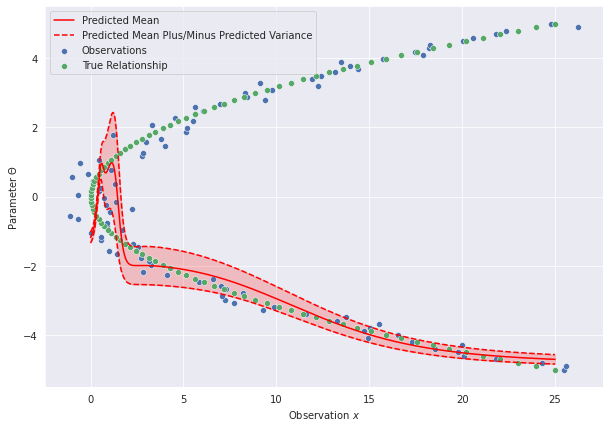

In [24]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model_func)

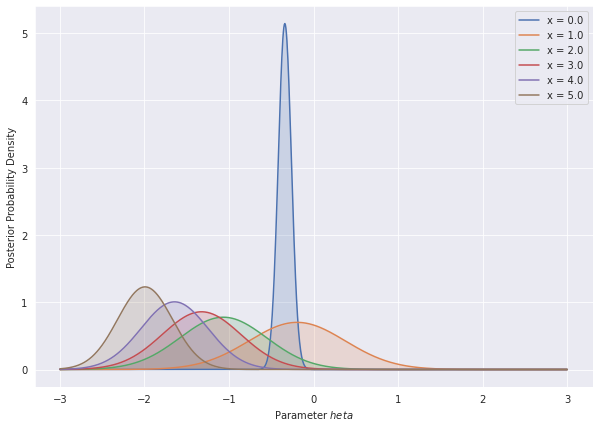

In [15]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)

<AxesSubplot:>

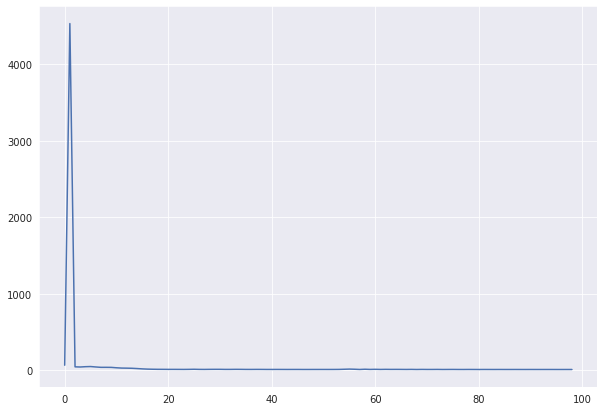

In [16]:
sns.lineplot(x=jnp.arange(len(loss)), y=jnp.array(loss))

In [17]:
theta = amortised_dist.sample_base(10, prngkey)
amortised_dist.logpdf_del_x(theta, data).shape

(100, 10, 1)